In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import logging # Allows us to check the progress of our LDA model
import re # Regex

# For Topic Modelling
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Visualising Topic Model
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns

# Word cloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [2]:
# Dataset: http://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter
bbc = pd.read_csv('bbchealth.txt',sep = "|",header = None, encoding='latin', error_bad_lines=False) # UK
cbc = pd.read_csv('cbchealth.txt',sep = "|",header = None, encoding='latin', error_bad_lines=False) # Canada
cnn = pd.read_csv('cnnhealth.txt',sep = "|",header = None, encoding='latin', error_bad_lines=False) # US

b'Skipping line 846: expected 3 fields, saw 4\nSkipping line 904: expected 3 fields, saw 4\nSkipping line 914: expected 3 fields, saw 4\nSkipping line 1264: expected 3 fields, saw 4\nSkipping line 1269: expected 3 fields, saw 4\nSkipping line 1293: expected 3 fields, saw 4\nSkipping line 1348: expected 3 fields, saw 4\nSkipping line 1430: expected 3 fields, saw 4\nSkipping line 1486: expected 3 fields, saw 4\nSkipping line 1710: expected 3 fields, saw 4\nSkipping line 2699: expected 3 fields, saw 4\nSkipping line 2728: expected 3 fields, saw 4\nSkipping line 3000: expected 3 fields, saw 4\n'
b'Skipping line 1422: expected 3 fields, saw 4\nSkipping line 1461: expected 3 fields, saw 4\nSkipping line 1468: expected 3 fields, saw 4\nSkipping line 1507: expected 3 fields, saw 4\nSkipping line 1547: expected 3 fields, saw 4\nSkipping line 1728: expected 3 fields, saw 4\nSkipping line 1738: expected 3 fields, saw 4\nSkipping line 1742: expected 3 fields, saw 4\nSkipping line 1847: expected 3 

# Data Cleaning

In [3]:
list_of_df = [bbc,cbc,cnn]

for i in range(len(list_of_df)):
    df = list_of_df[i]
    
    data = df[2].tolist()
    data = [re.sub('http://\S*\s?', '', sent) for sent in data] # Remove links
    data = [re.sub('\S*.com', '', sent) for sent in data] # Remove links
    data = [re.sub('@\S*', '', sent) for sent in data] # Remove mentions
    data = [re.sub('\S*.jpg', '', sent) for sent in data] # Remove images
    df[2] = data
    
    df[1] = pd.to_datetime(df[1]).apply(lambda x:x.strftime('%Y-%m')) # Convert to DateTime and group by month 
    df = df.sort_values(1) # Sort by month
    df.rename(columns={0:"remove",1:"datetime",2:"title"},inplace = True) # Rename columns
    df = df[[a for a in df.columns if a != "remove"]] # Remove redundant columns
    df = df.groupby(df.datetime)['title'].apply(' '.join).reset_index() # Group by Dates
    list_of_df[i] = df

In [4]:
# Save a copy of original text
bbc_text = copy.deepcopy(list_of_df[0].title)
cbc_text = copy.deepcopy(list_of_df[1].title)
cnn_text = copy.deepcopy(list_of_df[2].title)

In [5]:
list_of_df[0].head()

,datetime,title
0,2013-09,C. diff 'manslaughter' inquiry call VIDEO: 'I...
1,2013-10,Death home saw 'institutional abuse' Peek-a-b...
2,2013-11,Study links synaesthesia to autism 'I thought...
3,2013-12,Indian women who are choosing to be child-free...
4,2014-01,Obesity measure 'too high' for many Routine o...


# Pre-processing

In [6]:
# https://www.programcreek.com/python/example/107282/nltk.stem.WordNetLemmatizer

def preprocessing(text): 
    # tokenize into words
    tokens = list(gensim.utils.simple_preprocess(str(text), deacc=True))
    
    # remove stopwords
    stop = stopwords.words('english')
    stop.extend(['video','audio','health','nh','com','jpg']) # Extra stop words that are not removed by nltk
    tokens = [token for token in tokens if token not in stop]

    # lower capitalization
    tokens = [word.lower() for word in tokens]
    
    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]
    
    # remove words less than three letters
    tokens = [word for word in tokens if len(word) > 3]

    return tokens

In [7]:
# Process every row
for i in range(len(list_of_df)):
    list_of_df[i].title = list_of_df[i].title.apply(preprocessing)

In [8]:
# Retrieve back our data
bbc = list_of_df[0].title
cbc = list_of_df[1].title
cnn = list_of_df[2].title

# BBC

# Generating dictionary and corpus

In [9]:
dictionary_bbc = gensim.corpora.Dictionary(bbc) # Associate words to a numeric ID
# Filter out extreme values: token should appear between 20% to 50% of the corpus
dictionary_bbc.filter_extremes(no_below=0.2*dictionary_bbc.num_docs, no_above=0.5) 
corpus_bbc = [dictionary_bbc.doc2bow(doc) for doc in bbc]
print('Number of unique tokens: %d' % len(dictionary_bbc))
print('Number of documents: %d' % len(corpus_bbc))

Number of unique tokens: 555
Number of documents: 20


# Finding optimal number of topics

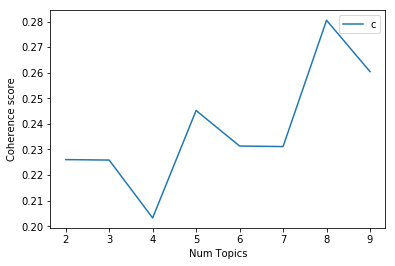

In [10]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters
limit=10; start=2; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_bbc, 
                                                        corpus=corpus_bbc, texts=bbc, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualise topic-word distribution

In [11]:
lda_model_bbc = model_list[3] # optimal model
vis = pyLDAvis.gensim.prepare(lda_model_bbc, corpus_bbc, dictionary_bbc)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.013939  0.010421       1        1  45.342731
2      0.010326 -0.036623       2        1  21.039837
3     -0.103806 -0.075672       3        1  16.277079
4      0.136021 -0.026838       4        1  12.154071
0     -0.028601  0.128712       5        1   5.186284, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
542   Default  16.000000       ashya  16.000000  30.0000  30.0000
404   Default  19.000000        data  19.000000  29.0000  29.0000
310   Default  17.000000        teen  17.000000  28.0000  28.0000
492   Default  18.000000     liberia  18.000000  27.0000  27.0000
18    Default  11.000000      better  11.000000  26.0000  26.0000
437   Default  22.000000      strike  22.000000  25.0000  25.0000
477   Default  22.000000      stroke  22.000000  24.0000  24.0000
373   Default  13.000000      record  13.000000  23.0000  23.0000
455   Default  10.000000     council  10.000000  22.0000  22.0000
391   Default   6.000000      tumour   6.000000  21.0000  21.0000
393   Default  11.000000        vote  11.000000  20.0000  20.0000
264   Default  14.000000       medic  14.000000  19.0000  19.0000
28    Default  11.000000  campaigner  11.000000  18.0000  18.0000
182   Default  11.000000     vitamin  11.000000  17.0000  17.0000
346   Default   7.000000        game   7.000000  16.0000  16.0000
232   Default  18.000000   emergency  18.000000  15.0000  15.0000
502   Default  20.000000   screening  20.000000  14.0000  14.0000
107   Default  23.000000       major  23.000000  13.0000  13.0000
286   Default  12.000000   pregnancy  12.000000  12.0000  12.0000
156   Default  15.000000       start  15.000000  11.0000  11.0000
155   Default  18.000000       sperm  18.000000  10.0000  10.0000
160   Default  10.000000      stress  10.000000   9.0000   9.0000
539   Default  10.000000    declares  10.000000   8.0000   8.0000
443   Default  15.000000       warns  15.000000   7.0000   7.0000
94    Default  10.000000        keep  10.000000   6.0000   6.0000
397   Default   7.000000     allergy   7.000000   5.0000   5.0000
168   Default   9.000000     tobacco   9.000000   4.0000   4.0000
108   Default  11.000000     measles  11.000000   3.0000   3.0000
361   Default  15.000000     medical  15.000000   2.0000   2.0000
204   Default  14.000000       begin  14.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
464    Topic5   0.816468       label   4.141363   1.3354  -5.6407
313    Topic5   0.816375       tough   4.152027   1.3327  -5.6408
325    Topic5   0.816382       alive   4.152343   1.3326  -5.6408
209    Topic5   1.497023       blind   7.616826   1.3323  -5.0344
467    Topic5   0.816456        math   4.167559   1.3290  -5.6407
454    Topic5   0.816388    consider   4.177795   1.3265  -5.6408
461    Topic5   0.816918     greater   4.193033   1.3235  -5.6401
439    Topic5   0.816525        swap   4.193297   1.3230  -5.6406
451    Topic5   0.816396      caring   4.203465   1.3204  -5.6408
373    Topic5   2.177383      record  13.721916   1.1183  -4.6598
264    Topic5   2.177442       medic  14.477179   1.0647  -4.6598
444    Topic5   1.496974       adult   9.244770   1.1385  -5.0345
352    Topic5   1.496940        kill   9.496442   1.1117  -5.0345
168    Topic5   1.496952     tobacco   9.594484   1.1014  -5.0345
239    Topic5   1.496942     getting  10.389429   1.0218  -5.0345
223    Topic5   1.497014       delay  10.391358   1.0217  -5.0344
94     Topic5   1.496875        keep  10.489614   1.0121  -5.0345
160    Topic5   1.496835      stress  10.504559   1.0107  -5.0346
228    Topic5   1.496935    drinking  11.173016   0.9491  -5.0345
148    Topic5   1.496950      saving  11.237200   0.9434  -5.0345
108    Topic5   1.496855     measles  11.273643   0.9401  -5.0345
394    Topic5  

# Using word cloud to infer our topics

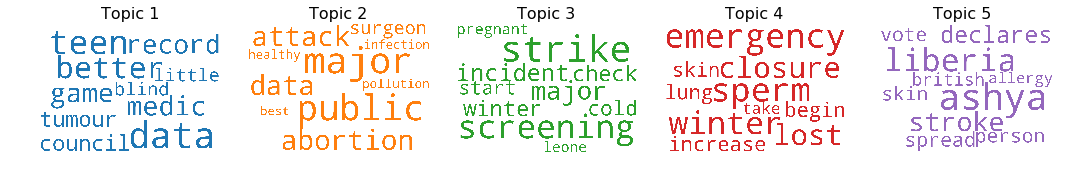

In [12]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_bbc.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Generating dominant topic for each document

In [13]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model_bbc, corpus=corpus_bbc, texts=bbc_text)

In [14]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['date', 'Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'title']
df_dominant_topic.date = list_of_df[0].datetime

# Show
df_dominant_topic.head(10)

,date,Dominant_Topic,Topic_Perc_Contrib,keywords,title
0,2013-09,1.0,0.7319,"major, public, abortion, attack, data, surgeon...",C. diff 'manslaughter' inquiry call VIDEO: 'I...
1,2013-10,1.0,0.9969,"major, public, abortion, attack, data, surgeon...",Death home saw 'institutional abuse' Peek-a-b...
2,2013-11,3.0,0.9968,"emergency, sperm, winter, closure, lost, begin...",Study links synaesthesia to autism 'I thought...
3,2013-12,1.0,0.6394,"major, public, abortion, attack, data, surgeon...",Indian women who are choosing to be child-free...
4,2014-01,1.0,0.9963,"major, public, abortion, attack, data, surgeon...",Obesity measure 'too high' for many Routine o...
5,2014-02,0.0,0.9964,"data, teen, better, game, medic, record, counc...",Children in adult psychiatric wards Drug lets...
6,2014-03,3.0,0.9972,"emergency, sperm, winter, closure, lost, begin...",Puffed out? Anonymous donor funds boy's surge...
7,2014-04,1.0,0.9963,"major, public, abortion, attack, data, surgeon...",Saudi health minister sacked Novartis in $16b...
8,2014-05,1.0,0.9966,"major, public, abortion, attack, data, surgeon...",AUDIO: Mother's grief after ambulance mix-up ...
9,2014-06,1.0,0.9967,"major, public, abortion, attack, data, surgeon...",Sunbathing 'may be addictive' Diabetes gene '...


# Top 10 words for each topic

In [15]:
df_topics_keyword_sorted = pd.DataFrame()

df_topics_keyword_sorted_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topics_keyword_sorted_grouped:
    df_topics_keyword_sorted = pd.concat([df_topics_keyword_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
df_topics_keyword_sorted.reset_index(drop=True, inplace=True)

# Format
df_topics_keyword_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_topics_keyword_sorted.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9964,"data, teen, better, game, medic, record, counc...",Children in adult psychiatric wards Drug lets...
1,1.0,0.9969,"major, public, abortion, attack, data, surgeon...",Death home saw 'institutional abuse' Peek-a-b...
2,2.0,0.9974,"strike, screening, major, incident, winter, ch...",Scans reveal cause of winter blues Man walks ...
3,3.0,0.9972,"emergency, sperm, winter, closure, lost, begin...",Puffed out? Anonymous donor funds boy's surge...
4,4.0,0.9966,"ashya, liberia, stroke, declares, spread, skin...",State of the NHS: Wales v England Patient-saf...


# Document-topic matrix

In [16]:
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = bbc[x] # Get the content of document (already preprocessed)
    new_doc_bow = dictionary_bbc.doc2bow(new_doc) # Form a BOW
    temp = lda_model_bbc.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib','title']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5"},
                       inplace=True)
# Display the table
doc_topic_table

,date,keywords,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,2013-09,"major, public, abortion, attack, data, surgeon...",0.06668,0.73193,0.06804,0.06667,0.06668
1,2013-10,"major, public, abortion, attack, data, surgeon...",0.00078,0.99688,0.00078,0.00078,0.00078
2,2013-11,"emergency, sperm, winter, closure, lost, begin...",0.00079,0.00080,0.00080,0.99681,0.00080
3,2013-12,"major, public, abortion, attack, data, surgeon...",0.00085,0.63941,0.00085,0.35805,0.00085
4,2014-01,"major, public, abortion, attack, data, surgeon...",0.00094,0.99625,0.00094,0.00094,0.00094
5,2014-02,"data, teen, better, game, medic, record, counc...",0.99645,0.00089,0.00089,0.00089,0.00089
6,2014-03,"emergency, sperm, winter, closure, lost, begin...",0.00070,0.00071,0.00071,0.99717,0.00071
7,2014-04,"major, public, abortion, attack, data, surgeon...",0.00091,0.99635,0.00091,0.00092,0.00091
8,2014-05,"major, public, abortion, attack, data, surgeon...",0.00084,0.99661,0.00085,0.00085,0.00085
9,2014-06,"major, public, abortion, attack, data, surgeon...",0.00083,0.99666,0.00084,0.00084,0.00083


# Plotting topic over time

In [17]:
order = [i for i in df_topics_keyword_sorted.Keywords]
order

['data, teen, better, game, medic, record, council, tumour, little, blind',
 'major, public, abortion, attack, data, surgeon, pollution, healthy, infection, best',
 'strike, screening, major, incident, winter, check, cold, start, pregnant, leone',
 'emergency, sperm, winter, closure, lost, begin, increase, lung, skin, take',
 'ashya, liberia, stroke, declares, spread, skin, person, vote, british, allergy']

In [18]:
list_of_docs = []
for i in range(1,6):
    temp = doc_topic_table[['date','keywords','Topic %s' %i]]
    temp.rename(columns={'Topic %s' %i: "share"}, inplace = True)
    list_of_docs.append(temp)
df = pd.concat(list_of_docs)
df.keywords = [i for i in order for j in range(20)]
df.rename(columns={'keywords': 'topic_keywords','Document_No': 'date'}, inplace=True)

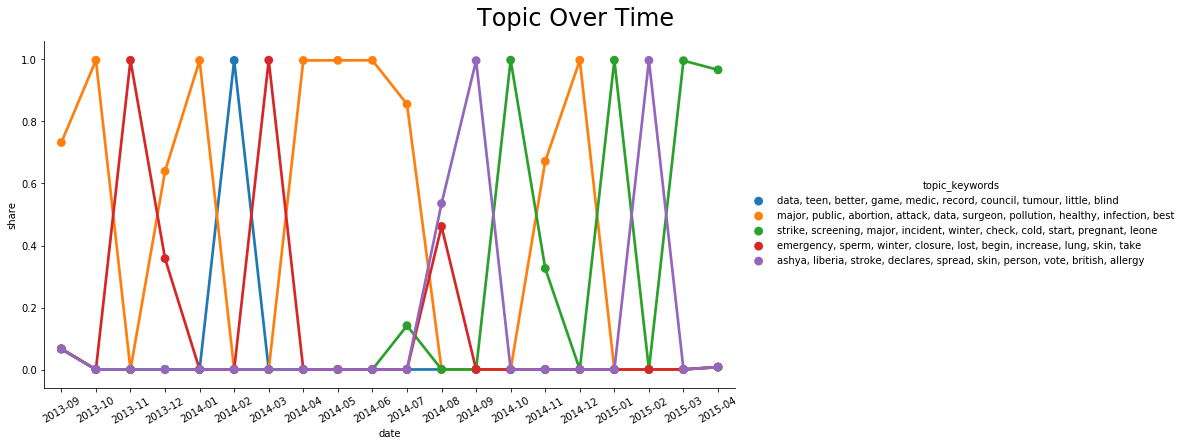

In [19]:
# http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
p = sns.factorplot(x="date", y='share', kind='point', hue_order=order, hue='topic_keywords',size=6, aspect=1.8, data=df)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Topic Over Time', fontsize=24)
p.set_xticklabels(rotation=30)
p

# CBC

# Generating dictionary and corpus

In [20]:
dictionary_cbc = gensim.corpora.Dictionary(cbc) # Associate words to a numeric ID
# Filter out extreme values: token should appear between 20% to 50% of the corpus
dictionary_cbc.filter_extremes(no_below=0.2*dictionary_cbc.num_docs, no_above=0.5) 
corpus_cbc = [dictionary_cbc.doc2bow(doc) for doc in cbc]
print('Number of unique tokens: %d' % len(dictionary_cbc))
print('Number of documents: %d' % len(corpus_cbc))

Number of unique tokens: 693
Number of documents: 25


# Finding optimal number of topics

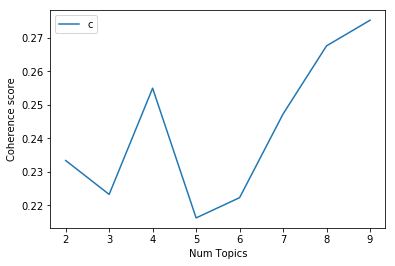

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters
limit=10; start=2; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_cbc, 
                                                        corpus=corpus_cbc, texts=cbc, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualise topic-word distribution

In [22]:
lda_model_cbc = model_list[2] # optimal model
vis = pyLDAvis.gensim.prepare(lda_model_cbc, corpus_cbc, dictionary_cbc)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.021034  0.027173       1        1  38.057770
0      0.119943 -0.046405       2        1  25.146639
3     -0.090158 -0.077458       3        1  20.248199
1     -0.008750  0.096690       4        1  16.547396, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
689   Default  44.000000       liberia  44.000000  30.0000  30.0000
680   Default  51.000000        sierra  51.000000  29.0000  29.0000
675   Default  51.000000         leone  51.000000  28.0000  28.0000
691   Default  18.000000    quarantine  18.000000  27.0000  27.0000
642   Default  28.000000         watch  28.000000  26.0000  26.0000
204   Default  27.000000         saudi  27.000000  25.0000  25.0000
83    Default  30.000000         trial  30.000000  24.0000  24.0000
98    Default  20.000000        arabia  20.000000  23.0000  23.0000
450   Default  16.000000          fact  16.000000  22.0000  22.0000
58    Default  13.000000     pregnancy  13.000000  21.0000  21.0000
34    Default  14.000000       growing  14.000000  20.0000  20.0000
688   Default  16.000000  experimental  16.000000  19.0000  19.0000
203   Default  11.000000          sars  11.000000  18.0000  18.0000
478   Default  11.000000      sinclair  11.000000  17.0000  17.0000
29    Default   6.000000        father   6.000000  16.0000  16.0000
163   Default  13.000000      montreal  13.000000  15.0000  15.0000
415   Default  13.000000         sends  13.000000  14.0000  14.0000
551   Default  54.000000       measles  54.000000  13.0000  13.0000
442   Default  10.000000         brian  10.000000  12.0000  12.0000
455   Default  12.000000       inquest  12.000000  11.0000  11.0000
130   Default  11.000000       driving  11.000000  10.0000  10.0000
673   Default  17.000000          ford  17.000000   9.0000   9.0000
307   Default  13.000000        online  13.000000   8.0000   8.0000
237   Default  11.000000        tumour  11.000000   7.0000   7.0000
135   Default   6.000000         extra   6.000000   6.0000   6.0000
6     Default  21.000000          bird  21.000000   5.0000   5.0000
156   Default  17.000000          live  17.000000   4.0000   4.0000
150   Default  15.000000        infant  15.000000   3.0000   3.0000
87    Default  16.000000          wait  16.000000   2.0000   2.0000
690   Default   9.000000        mobile   9.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
342    Topic4   4.884361       vitamin   9.705175   1.1123  -5.4401
649    Topic4   2.672546          past   5.348005   1.1052  -6.0431
244    Topic4   3.532712       windsor   7.125837   1.0973  -5.7641
120    Topic4   2.640516         delay   5.338467   1.0950  -6.0552
34     Topic4   7.012561       growing  14.221106   1.0919  -5.0785
43     Topic4   4.282940       infects   8.820419   1.0765  -5.5715
508    Topic4   3.446973        impact   7.118532   1.0737  -5.7887
37     Topic4   6.329000        higher  13.288383   1.0572  -5.1810
103    Topic4   3.759890      autistic   8.051357   1.0375  -5.7018
98     Topic4   9.333694        arabia  20.409615   1.0166  -4.7925
93     Topic4   5.725333     alzheimer  12.457560   1.0215  -5.2813
204    Topic4  10.517859         saudi  27.550295   0.8360  -4.6731
82     Topic4   5.060559         trend  11.568277   0.9722  -5.4047
325    Topic4   5.040399          skin  11.547119   0.9700  -5.4087
87     Topic4   6.632037          wait  16.835135   0.8674  -5.1343
15     Topic4   5.001102         china  11.516008   0.9649  -5.4165
153    Topic4   4.667279          keep  10.646486   0.9743  -5.4856
61     Topic4   4.416178       project   9.830952   0.9987  -5.5409
12     Topic4   5.255431         chemo  13.456631   0.8587  -5.3669
6      Topic4   6.724210          bird  21.345501   0.6438  -5.1205
25     Topic4   5.191720     

# Using word cloud to infer our topics

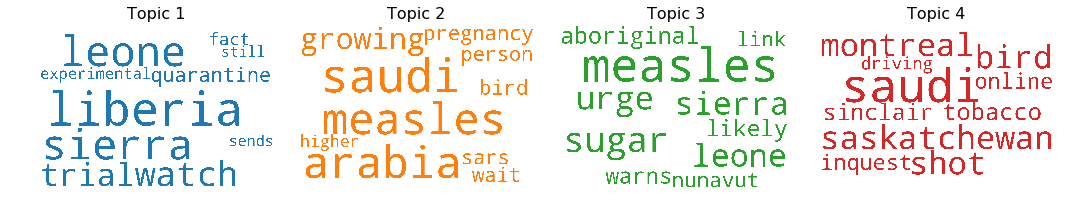

In [23]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_cbc.show_topics(formatted=False)

fig, axes = plt.subplots(1, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Generating dominant topic for each document

In [24]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model_cbc, corpus=corpus_cbc, texts=cbc_text)

In [25]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['date', 'Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'title']
df_dominant_topic.date = list_of_df[1].datetime

# Show
df_dominant_topic.head(10)

,date,Dominant_Topic,Topic_Perc_Contrib,keywords,title
0,2013-04,1.0,0.9929,"saudi, arabia, measles, growing, pregnancy, bi...",Health Canada to stop sales of small magnets ...
1,2013-05,3.0,0.3927,"saudi, saskatchewan, montreal, shot, bird, tob...",Needed: New approaches to defuse 'suicide cont...
2,2013-06,2.0,0.5699,"measles, sugar, urge, leone, sierra, aborigina...",AHS to reverse controversial home care decisio...
3,2013-07,2.0,0.9964,"measles, sugar, urge, leone, sierra, aborigina...",Aging population will see more retinal injurie...
4,2013-08,3.0,0.5173,"saudi, saskatchewan, montreal, shot, bird, tob...",'Super agers' sought for brain health study M...
5,2013-09,1.0,0.9956,"saudi, arabia, measles, growing, pregnancy, bi...",Women and alcoholism: author describes âglob...
6,2013-10,3.0,0.9969,"saudi, saskatchewan, montreal, shot, bird, tob...",Reser's macaroni salad recall expands over Lis...
7,2013-11,2.0,0.5842,"measles, sugar, urge, leone, sierra, aborigina...",Progesterone tablets for IFV recalled Male in...
8,2013-12,2.0,0.6722,"measles, sugar, urge, leone, sierra, aborigina...",Peanut butter drive by school ends after plain...
9,2014-01,3.0,0.9969,"saudi, saskatchewan, montreal, shot, bird, tob...",How much do you make? Nova Scotia doctors want...


# Top 10 words for each topic

In [26]:
df_topics_keyword_sorted = pd.DataFrame()

df_topics_keyword_sorted_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topics_keyword_sorted_grouped:
    df_topics_keyword_sorted = pd.concat([df_topics_keyword_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
df_topics_keyword_sorted.reset_index(drop=True, inplace=True)

# Format
df_topics_keyword_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_topics_keyword_sorted.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9985,"liberia, leone, sierra, watch, trial, quaranti...",The truth behind Ebola: Is the Ebola virus air...
1,1.0,0.9974,"saudi, arabia, measles, growing, pregnancy, bi...",Shorter shifts for surgical interns may not be...
2,2.0,0.9972,"measles, sugar, urge, leone, sierra, aborigina...",Want your skin to look 20 to 30 years younger?...
3,3.0,0.9974,"saudi, saskatchewan, montreal, shot, bird, tob...",Quebec's 'dying with dignity' bill passage exp...


# Document-topic matrix

In [27]:
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = cbc[x] # Get the content of document (already preprocessed)
    new_doc_bow = dictionary_cbc.doc2bow(new_doc) # Form a BOW
    temp = lda_model_cbc.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib','title']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4"},
                       inplace=True)
# Display the table
doc_topic_table

,date,keywords,Topic 1,Topic 2,Topic 3,Topic 4
0,2013-04,"saudi, arabia, measles, growing, pregnancy, bi...",0.00236,0.99289,0.00239,0.00236
1,2013-05,"saudi, saskatchewan, montreal, shot, bird, tob...",0.00106,0.36080,0.24546,0.39267
2,2013-06,"measles, sugar, urge, leone, sierra, aborigina...",0.00143,0.20709,0.56990,0.22157
3,2013-07,"measles, sugar, urge, leone, sierra, aborigina...",0.00120,0.00122,0.99637,0.00121
4,2013-08,"saudi, saskatchewan, montreal, shot, bird, tob...",0.00135,0.04069,0.44067,0.51729
5,2013-09,"saudi, arabia, measles, growing, pregnancy, bi...",0.00144,0.99563,0.00147,0.00146
6,2013-10,"saudi, saskatchewan, montreal, shot, bird, tob...",0.00102,0.00102,0.00103,0.99692
7,2013-11,"measles, sugar, urge, leone, sierra, aborigina...",0.00129,0.00129,0.58417,0.41324
8,2013-12,"measles, sugar, urge, leone, sierra, aborigina...",0.00136,0.32505,0.67221,0.00138
9,2014-01,"saudi, saskatchewan, montreal, shot, bird, tob...",0.00102,0.00102,0.00103,0.99693


# Plotting topic over time

In [28]:
order = [i for i in df_topics_keyword_sorted.Keywords]
order

['liberia, leone, sierra, watch, trial, quarantine, fact, experimental, sends, still',
 'saudi, arabia, measles, growing, pregnancy, bird, sars, wait, person, higher',
 'measles, sugar, urge, leone, sierra, aboriginal, likely, warns, nunavut, link',
 'saudi, saskatchewan, montreal, shot, bird, tobacco, sinclair, inquest, online, driving']

In [29]:
list_of_docs = []
for i in range(1,5):
    temp = doc_topic_table[['date','keywords','Topic %s' %i]]
    temp.rename(columns={'Topic %s' %i: "share"}, inplace = True)
    list_of_docs.append(temp)
df = pd.concat(list_of_docs)
df.keywords = [i for i in order for j in range(25)] # loop through number of docs
df.rename(columns={'keywords': 'topic_keywords','Document_No': 'date'}, inplace=True)

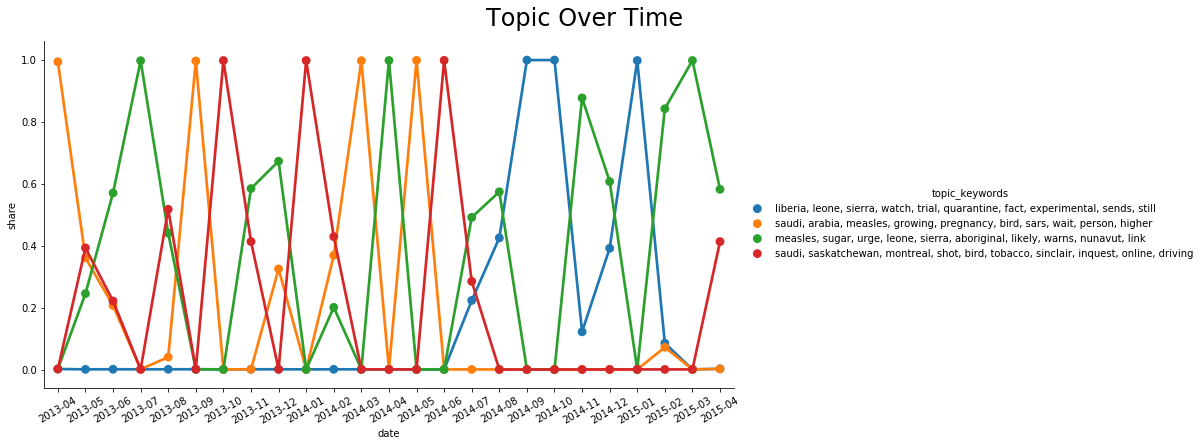

In [30]:
# http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
p = sns.factorplot(x="date", y='share', kind='point', hue_order=order, hue='topic_keywords',size=6, aspect=1.8, data=df)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Topic Over Time', fontsize=24)
p.set_xticklabels(rotation=30)
p

# CNN

# Generating dictionary and corpus

In [31]:
dictionary_cnn = gensim.corpora.Dictionary(cnn) # Associate words to a numeric ID
# Filter out extreme values: token should appear between 20% to 50% of the corpus
dictionary_cnn.filter_extremes(no_below=0.2*dictionary_cnn.num_docs, no_above=0.5) 
corpus_cnn = [dictionary_cnn.doc2bow(doc) for doc in cnn]
print('Number of unique tokens: %d' % len(dictionary_cnn))
print('Number of documents: %d' % len(corpus_cnn))

Number of unique tokens: 437
Number of documents: 32


# Finding optimal number of topics

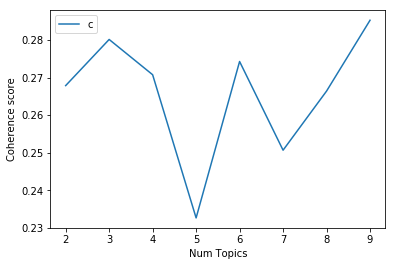

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters
limit=10; start=2; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_cnn, 
                                                        corpus=corpus_cnn, texts=cnn, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualise topic-word distribution

In [33]:
lda_model_cnn = model_list[2] # optimal model
vis = pyLDAvis.gensim.prepare(lda_model_cnn, corpus_cnn, dictionary_cnn)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.036294  0.014468       1        1  55.039345
3      0.009321 -0.128371       2        1  21.965521
1     -0.134933  0.042373       3        1  11.501711
2      0.089318  0.071530       4        1  11.493415, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
435   Default  108.000000        ebola  108.000000  30.0000  30.0000
430   Default   44.000000   cnnparents   44.000000  29.0000  29.0000
219   Default   31.000000   meningitis   31.000000  28.0000  28.0000
225   Default   33.000000    obamacare   33.000000  27.0000  27.0000
424   Default   18.000000         mers   18.000000  26.0000  26.0000
67    Default   30.000000       breast   30.000000  25.0000  25.0000
432   Default   17.000000      measles   17.000000  24.0000  24.0000
132   Default   21.000000         news   21.000000  23.0000  23.0000
45    Default   25.000000      symptom   25.000000  22.0000  22.0000
150   Default   31.000000         safe   31.000000  21.0000  21.0000
269   Default   22.000000    treatment   22.000000  20.0000  20.0000
116   Default   12.000000     inspired   12.000000  19.0000  19.0000
421   Default   18.000000   alzheimers   18.000000  18.0000  18.0000
110   Default   50.000000  humanfactor   50.000000  17.0000  17.0000
76    Default   28.000000         city   28.000000  16.0000  16.0000
237   Default   17.000000     pregnant   17.000000  15.0000  15.0000
127   Default   23.000000       making   23.000000  14.0000  14.0000
339   Default   18.000000      support   18.000000  13.0000  13.0000
258   Default   26.000000       spread   26.000000  12.0000  12.0000
12    Default   25.000000       expert   25.000000  11.0000  11.0000
153   Default   20.000000         shot   20.000000  10.0000  10.0000
272   Default   14.000000      working   14.000000   9.0000   9.0000
303   Default   23.000000     research   23.000000   8.0000   8.0000
434   Default   10.000000     suggests   10.000000   7.0000   7.0000
364   Default   13.000000         term   13.000000   6.0000   6.0000
433   Default   14.000000     official   14.000000   5.0000   5.0000
238   Default   23.000000      prevent   23.000000   4.0000   4.0000
307   Default   26.000000       secret   26.000000   3.0000   3.0000
48    Default   17.000000         vote   17.000000   2.0000   2.0000
179   Default   21.000000        young   21.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
153    Topic4    6.394410         shot   20.553434   0.9958  -4.7704
58     Topic4    3.727336      athlete   12.154557   0.9814  -5.3101
103    Topic4    4.718653         hand   15.689555   0.9619  -5.0743
189    Topic4    5.599576         cold   18.745958   0.9551  -4.9031
187    Topic4    3.529559       battle   12.021843   0.9378  -5.3646
10     Topic4    5.789616     disorder   20.029549   0.9223  -4.8697
41     Topic4    3.755373    something   13.082072   0.9153  -5.3026
194    Topic4    2.853716       debate   10.219765   0.8877  -5.5772
388    Topic4    2.856298       excuse   10.240549   0.8866  -5.5763
127    Topic4    6.627483       making   23.769451   0.8862  -4.7346
422    Topic4    3.184901   antibiotic   11.471384   0.8820  -5.4674
118    Topic4    3.699227    insurance   13.513169   0.8679  -5.3177
12     Topic4    6.749877       expert   25.189823   0.8465  -4.7163
428    Topic4    1.993863   understand    7.449601   0.8453  -5.9357
81     Topic4    3.726856         cure   14.056579   0.8359  -5.3102
384    Topic4    2.880133         well   11.071564   0.8169  -5.5680
150    Topic4    8.308016         safe   31.975386   0.8157  -4.5086
264    Topic4    3.761619        thank   15.662536   0.7370  -5.3010
51     Topic4    5.269875       affect   24.102337   0.6431  -4.9638
38     Topic4    4.534451         plan   20.7

# Using word cloud to infer our topics

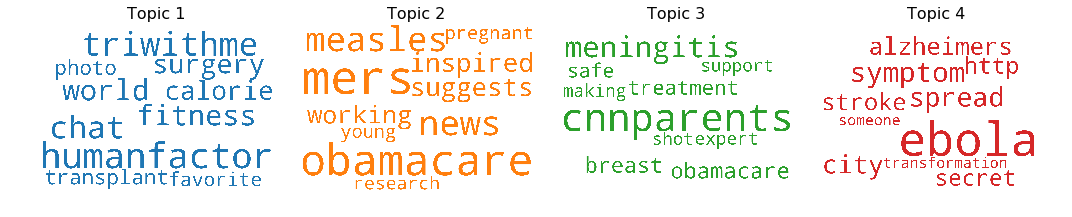

In [34]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_cnn.show_topics(formatted=False)

fig, axes = plt.subplots(1, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Generating dominant topic for each document

In [35]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model_cnn, corpus=corpus_cnn, texts=cnn_text)

In [36]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['date', 'Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'title']
df_dominant_topic.date = list_of_df[2].datetime

# Show
df_dominant_topic.head(10)

,date,Dominant_Topic,Topic_Perc_Contrib,keywords,title
0,2012-08,0.0,0.9849,"humanfactor, triwithme, chat, world, fitness, ...",Robin Roberts' cancer diagnosis One-handed ki...
1,2012-09,0.0,0.9963,"humanfactor, triwithme, chat, world, fitness, ...",First mother-to-daughter uterine transplant a ...
2,2012-10,2.0,0.9970,"cnnparents, meningitis, obamacare, breast, tre...",Training the brain to stress less Treat cheer...
3,2012-11,0.0,0.9962,"humanfactor, triwithme, chat, world, fitness, ...",RT Curiouser and curiouser. I'm on CNN. With ...
4,2012-12,0.0,0.9944,"humanfactor, triwithme, chat, world, fitness, ...",RT great contribution to the misunderstandin...
5,2013-01,0.0,0.9966,"humanfactor, triwithme, chat, world, fitness, ...",RT 30 degrees outside! Walking the dog this m...
6,2013-02,0.0,0.9965,"humanfactor, triwithme, chat, world, fitness, ...",Guess who's joining for the Malibu Tri?! Uh...
7,2013-03,0.0,0.9966,"humanfactor, triwithme, chat, world, fitness, ...",A wounded vet's slow recovery #iraq #anniversa...
8,2013-04,0.0,0.9970,"humanfactor, triwithme, chat, world, fitness, ...",Today's #getfit tip: Go outside! Do a fun acti...
9,2013-05,0.0,0.9972,"humanfactor, triwithme, chat, world, fitness, ...",Tornado hits Oklahoma hospital 10-year-old bo...


# Top 10 words for each topic

In [37]:
df_topics_keyword_sorted = pd.DataFrame()

df_topics_keyword_sorted_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topics_keyword_sorted_grouped:
    df_topics_keyword_sorted = pd.concat([df_topics_keyword_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
df_topics_keyword_sorted.reset_index(drop=True, inplace=True)

# Format
df_topics_keyword_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_topics_keyword_sorted.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9972,"humanfactor, triwithme, chat, world, fitness, ...",Tornado hits Oklahoma hospital 10-year-old bo...
1,1.0,0.9965,"mers, obamacare, news, measles, inspired, sugg...",ICYMI over the weekend: Health officials belie...
2,2.0,0.9979,"cnnparents, meningitis, obamacare, breast, tre...",Ryan Freel is the first MLB player to be diagn...
3,3.0,0.9971,"ebola, symptom, spread, city, alzheimers, stro...",Childhood mental health disabilities increased...


# Document-topic matrix

In [38]:
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = cnn[x] # Get the content of document (already preprocessed)
    new_doc_bow = dictionary_cnn.doc2bow(new_doc) # Form a BOW
    temp = lda_model_cnn.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib','title']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4"},
                       inplace=True)
# Display the table
doc_topic_table

,date,keywords,Topic 1,Topic 2,Topic 3,Topic 4
0,2012-08,"humanfactor, triwithme, chat, world, fitness, ...",0.98489,0.00506,0.00503,0.00502
1,2012-09,"humanfactor, triwithme, chat, world, fitness, ...",0.99630,0.00124,0.00122,0.00124
2,2012-10,"cnnparents, meningitis, obamacare, breast, tre...",0.00101,0.00098,0.99701,0.00100
3,2012-11,"humanfactor, triwithme, chat, world, fitness, ...",0.99617,0.00126,0.00130,0.00127
4,2012-12,"humanfactor, triwithme, chat, world, fitness, ...",0.99444,0.00184,0.00188,0.00185
5,2013-01,"humanfactor, triwithme, chat, world, fitness, ...",0.99659,0.00113,0.00114,0.00113
6,2013-02,"humanfactor, triwithme, chat, world, fitness, ...",0.99651,0.00116,0.00117,0.00116
7,2013-03,"humanfactor, triwithme, chat, world, fitness, ...",0.99660,0.00114,0.00113,0.00113
8,2013-04,"humanfactor, triwithme, chat, world, fitness, ...",0.99703,0.00098,0.00099,0.00100
9,2013-05,"humanfactor, triwithme, chat, world, fitness, ...",0.99719,0.00094,0.00093,0.00094


# Plotting topic over time

In [39]:
order = [i for i in df_topics_keyword_sorted.Keywords]
order

['humanfactor, triwithme, chat, world, fitness, surgery, calorie, transplant, photo, favorite',
 'mers, obamacare, news, measles, inspired, suggests, working, pregnant, young, research',
 'cnnparents, meningitis, obamacare, breast, treatment, safe, expert, making, support, shot',
 'ebola, symptom, spread, city, alzheimers, stroke, http, secret, transformation, someone']

In [40]:
list_of_docs = []
for i in range(1,5):
    temp = doc_topic_table[['date','keywords','Topic %s' %i]]
    temp.rename(columns={'Topic %s' %i: "share"}, inplace = True)
    list_of_docs.append(temp)
df = pd.concat(list_of_docs)
df.keywords = [i for i in order for j in range(32)] # loop through number of docs
df.rename(columns={'keywords': 'topic_keywords','Document_No': 'date'}, inplace=True)

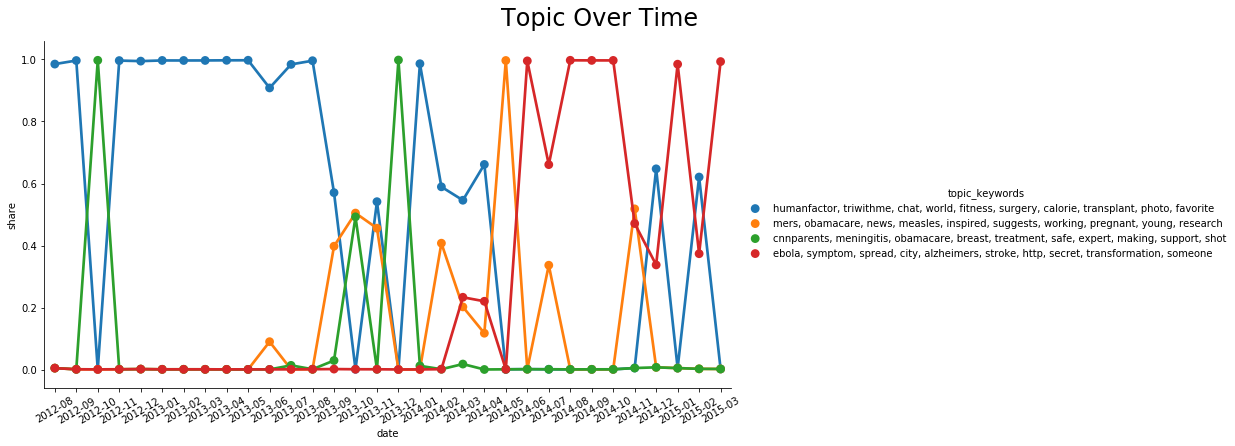

In [41]:
# http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
p = sns.factorplot(x="date", y='share', kind='point', hue_order=order, hue='topic_keywords',size=6, aspect=1.8, data=df)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Topic Over Time', fontsize=24)
p.set_xticklabels(rotation=30)
p

# References:


1. Inspiration: https://towardsdatascience.com/thats-mental-using-lda-topic-modeling-to-investigate-the-discourse-on-mental-health-over-time-11da252259c3
2. Dataset: http://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter
3. Pre-processing: https://www.programcreek.com/python/example/107282/nltk.stem.WordNetLemmatizer
4. Dominant topic: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
5. Word cloud: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
6. TOT: http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
7. Conclusion: https://medium.com/@alexisperrier/topic-modeling-of-twitter-timelines-in-python-bb91fa90d98d
